<a href="https://colab.research.google.com/github/Yuchao-ho/Head-CT-Age-Prediction/blob/main/Project__Thread__Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q einops
!pip install -q pydicom Pillow
!pip install -q pytorch_lightning
!pip install -q adabelief_pytorch
!pip install -q tqdm

In [2]:
import os
import cv2
import numpy as np
import pydicom
from PIL import Image
import matplotlib.pyplot as plt

import torch
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import random

import torch.nn.functional as F
from einops import rearrange, repeat
from torch import nn

import pytorch_lightning as pl
from adabelief_pytorch import AdaBelief
from torchmetrics import MaxMetric, MinMetric, MeanMetric
from IPython.display import clear_output

from time import sleep
from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def normalize_image(image):
    image = image - np.min(image)
    return image / np.max(image)

def denoiseImage(slice_3d_tensor):
  depth, height, width = slice_3d_tensor.shape
  resize_transform = transforms.Compose([
            transforms.Resize(224, antialias=True),  # Resize so the smallest side is 128, maintaining aspect ratio
            transforms.CenterCrop((128, 128))  # Center crop to get the exact size
        ])
  resize_slice_list = [resize_transform(slice_3d_tensor[i,:,:].unsqueeze(0)) for i in range(depth)]
  resized_tensor = torch.stack(resize_slice_list, dim=1)
  #print(f"stacked img size: {resized_tensor.size()}")
  standardized_tensor = torch.nn.functional.interpolate(resized_tensor.unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=True)
  return standardized_tensor.squeeze(0)

def create_3D_slice(patient_dir, patient_data):

  length_patient_slice = len(os.listdir(patient_dir))
  if length_patient_slice <= 128:
    dcm_path_list = [os.path.join(patient_dir, dcm_file) for dcm_file in os.listdir(patient_dir)]
  else:
    index_list = random.sample(range(len(os.listdir(patient_dir))),128)
    dcm_path_list = [os.path.join(patient_dir, os.listdir(patient_dir)[index]) for index in index_list]

  patient_slice = [pydicom.dcmread(dcm_path, force= True) for dcm_path in dcm_path_list]
  #index_list = random.sample(range(length_patient_slice),64) if length_patient_slice >= 64 else random.sample(range(length_patient_slice),length_patient_slice)

  patient_slice = sorted(patient_slice, key=lambda s: s.ImagePositionPatient[2])  # sort slices by location
  slice_3d_arr = np.stack([s.pixel_array for s in patient_slice]).astype(np.float32)
  if patient_slice[0].PhotometricInterpretation == "MONOCHROME1":
    slice_3d_arr = np.invert(slice_3d_arr)
  slice_3d = torch.from_numpy(slice_3d_arr)
  slice_3d = denoiseImage(slice_3d)

  age = list(patient_slice[0].PatientAge)
  age = int(''.join(age[:-1]))
  age = np.array([(age//5)+1])
  age = torch.from_numpy(age)
  patient_data["imgs"] = slice_3d
  patient_data["age"] = age

class PatientDataset(Dataset):
  def __init__(self, based_dir, transform=None):
    self.based_dir = based_dir
    self.transform = transform
    self.data_store = []
    with ThreadPoolExecutor(max_workers=min(len(os.listdir(self.based_dir)), 240)) as executor:
        patient_dir_list = [os.path.join(self.based_dir, sub_dir) for sub_dir in os.listdir(self.based_dir)]
        patient_data = {"imgs": [], "age": 0}
        futures = [executor.submit(create_3D_slice, patient_dir, patient_data) for  patient_dir in patient_dir_list]
        for future in futures:
            future.result()
            self.data_store.append(patient_data)


  def __len__(self):
    return len(os.listdir(self.based_dir))

  def __getitem__(self, index):
    patient_data = self.data_store[index]
    sample = patient_data["imgs"]
    agemark = patient_data["age"]

    if self.transform:
      sample = self.transform(sample)
      agemark = self.transform(agemark)
    return sample, agemark

In [5]:
patient_dataset = PatientDataset(based_dir="/content/drive/MyDrive/Experiment_Dataset")


In [6]:
train_set, test_set = random_split(patient_dataset, [0.8, 0.2])
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

for sample, age in train_loader:
  print(sample.size())
  print(age)
  break

torch.Size([1, 1, 128, 128, 128])
tensor([[14]])


In [7]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using device: {device}")

Using device: cuda


In [8]:
class APTx(nn.Module):
    def __init__(self, num_channels, alpha=1.0, beta=1.0, gamma=0.5):
        super(APTx, self).__init__()
        self.alpha = nn.Parameter(torch.full((num_channels,), alpha, dtype=torch.float32))
        self.beta = nn.Parameter(torch.full((num_channels,), beta, dtype=torch.float32))
        self.gamma = nn.Parameter(torch.full((num_channels,), gamma, dtype=torch.float32))

    def forward(self, x):
        # Adjust the shape of the parameters to match the input dimensions
        # This assumes the channel dimension is always the second one (as in NCHW or similar formats)
        dims = [1, -1] + [1] * (x.dim() - 2)
        alpha = self.alpha.view(*dims)
        beta = self.beta.view(*dims)
        gamma = self.gamma.view(*dims)
        tanh_beta_x = torch.tanh(beta * x)
        phi_x = (alpha + tanh_beta_x) * gamma * x
        return phi_x

    def extra_repr(self):
        return 'num_channels={}, alpha={}, beta={}, gamma={}'.format(self.alpha.numel(), self.alpha[0].item(),
                                                                     self.beta[0].item(), self.gamma[0].item())

# both ChannelAttention and SpatialAttention were inspired by CBAM, implemented in pytorch and adapted for 3D
# additionally, I added more complexity, but I have not checked whether this increases performance or not
class ChannelAttention3D(nn.Module):
    def __init__(self, in_channels, reduction_ratio=1):
        super(ChannelAttention3D, self).__init__()
        reduced_channels = in_channels // reduction_ratio  # Ensure at least 4 channels
        self.avg_pool = nn.AdaptiveAvgPool3d(1)  # Adjusted for 3D
        self.max_pool = nn.AdaptiveMaxPool3d(1)  # Adjusted for 3D
        self.fc = nn.Sequential(
            nn.Linear(in_channels, reduced_channels),
            nn.LayerNorm(reduced_channels),
            APTx(reduced_channels),
            nn.Linear(reduced_channels, reduced_channels),
            nn.LayerNorm(reduced_channels),
            APTx(reduced_channels),
            nn.Linear(reduced_channels, reduced_channels),
            nn.LayerNorm(reduced_channels),
            APTx(reduced_channels),
            nn.Linear(reduced_channels, in_channels),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _, _ = x.size()  # Adjusted for 3D
        # Squeeze
        y_a = self.avg_pool(x).view(b, c)
        y_m = self.max_pool(x).view(b, c)
        # Excitation
        y_a = self.fc(y_a).view(b, c, 1, 1, 1)  # Adjusted for 3D
        y_m = self.fc(y_m).view(b, c, 1, 1, 1)  # Adjusted for 3D
        # Scale
        return x * self.sigmoid(y_a.expand_as(x) + y_m.expand_as(x))

class SpatialAttention3D(nn.Module):
    def __init__(self, kernel_size=5):
        super(SpatialAttention3D, self).__init__()
        padding = kernel_size // 2
        self.norm = nn.GroupNorm(1, 2, affine=True)
        self.conv1 = nn.Conv3d(2, 2, kernel_size, padding=padding)  # Adjusted for 3D
        self.activation = APTx(2)
        self.conv2 = nn.Conv3d(2, 1, kernel_size, padding=padding)  # Adjusted for 3D
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_m = torch.cat([avg_out, max_out], dim=1)
        x_m = self.norm(x_m)
        x_m = self.conv1(x_m)
        x_m = self.activation(x_m)
        x_m = self.conv2(x_m)
        return x * self.sigmoid(x_m)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, module=nn.Conv3d, p=0.2):
        super(ConvBlock, self).__init__()
        self.conv = module(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.se = ChannelAttention3D(out_channels)
        self.sa = SpatialAttention3D()
        self.norm = nn.GroupNorm(1, out_channels, affine=True)
        self.activation = APTx(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        x = self.se(x)
        x = self.sa(x)
        return self.norm(x)

class HeadCT3DTinyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_history = []
        self.lr_history = []
        self.weight_history = []
        #self.loss_fn = nn.L1Loss()
        self.min_metric = MinMetric()
        self.max_metric = MaxMetric()
        self.mean_metric = MeanMetric()
        self.reduce = nn.MaxPool3d(2, stride=2)
        self.norm = nn.GroupNorm(1, 1, affine=True)
        self.conv1 = ConvBlock(1, 32)  # 128x128x128
        self.conv2 = ConvBlock(32, 64)  # 64x64x64
        self.conv3 = ConvBlock(64, 96)  # 32x32x32
        self.conv4 = ConvBlock(96, 128)  # 16x16x16
        self.conv5 = ConvBlock(128, 160)  # 8x8x8
        self.conv6 = ConvBlock(160, 192)  # 4x4x4
        self.classifier = nn.Linear(4 * 4 * 4 * 192, 20)

    def forward(self, x):
        #x = x.squeeze(0)
        x = self.norm(x)
        x = self.conv1(x)
        x = self.reduce(x)
        x = self.conv2(x)
        x = self.reduce(x)
        x = self.conv3(x)
        x = self.reduce(x)
        x = self.conv4(x)
        x = self.reduce(x)
        x = self.conv5(x)
        x = self.reduce(x)
        x = self.conv6(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #x = torch.mean(x, dim=1).unsqueeze(-1)
        return x

def test(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, ages in loader:
            inputs, ages = inputs.to(device), ages.to(device)
            output = model(inputs)
            output, max_index = torch.max(output, dim=1)
            loss = criterion(max_index.unsqueeze(0), ages.float())
            total_loss += loss.item()
    loss = total_loss / len(loader)
    return loss

In [10]:
import torch.optim as optim
num_epochs = 30
criterion = nn.L1Loss()
criterion_loss = nn.MSELoss()
predict_model = HeadCT3DTinyNet()
predict_model.to(device)
optimizer = optim.Adam(predict_model.parameters(), lr=0.01, weight_decay=2e-3)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=1e-5, total_iters=num_epochs)
predict_model.train()
loss_list = []
acc_list = []

for epoch in range(num_epochs):
  total_loss = 0.0
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, ages in tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        inputs, ages = inputs.to(device), ages.to(device)
        optimizer.zero_grad()
        output = predict_model(inputs)
        output, max_index = torch.max(output, dim=1)
        #max_index = (max_index + 1).float()
        #print(f"max index: {max_index}")
        #print(f"ages_truth: {ages}")
        loss = criterion(output.unsqueeze(0), ages.float())
        #loss.requires_grad = True
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        tepoch.set_postfix(loss=loss.item())
        sleep(0.1)
    scheduler.step()
    loss_list.append(total_loss/len(train_loader))
    test_loss = test(predict_model, test_loader, criterion_loss)
    acc_list.append(test_loss)
    if (epoch + 1) % 5 == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_loader):.4f}, Test Loss: {test_loss:.4f}")


Epoch 4: 100%|██████████| 266/266 [02:51<00:00,  1.55batch/s, loss=0.155]


Epoch [5/30], Train Loss: 0.2451, Test Loss: 0.0097


Epoch 9: 100%|██████████| 266/266 [02:50<00:00,  1.56batch/s, loss=0.211]


Epoch [10/30], Train Loss: 0.1269, Test Loss: 0.0944


Epoch 14: 100%|██████████| 266/266 [02:49<00:00,  1.57batch/s, loss=0.0524]


Epoch [15/30], Train Loss: 0.0712, Test Loss: 0.0050


Epoch 19: 100%|██████████| 266/266 [02:49<00:00,  1.57batch/s, loss=0.0482]


Epoch [20/30], Train Loss: 0.0549, Test Loss: 0.0022


Epoch 24: 100%|██████████| 266/266 [02:49<00:00,  1.57batch/s, loss=1.34e-5]


Epoch [25/30], Train Loss: 0.0134, Test Loss: 0.0007


Epoch 29: 100%|██████████| 266/266 [02:49<00:00,  1.57batch/s, loss=0.00272]


Epoch [30/30], Train Loss: 0.0045, Test Loss: 0.0000


In [24]:
predict_model.eval()
with torch.no_grad():
  for inputs, ages in test_loader:
    inputs, ages = inputs.to(device), ages.to(device)
    output = predict_model(inputs)
    output, max_index = torch.max(output, dim=1)
    print("Example prediction")
    print(f"Prediction: ({output.item()*5-5}, {output.item()*5}), correct: ({ages.item()*5-5}, {ages.item()*5})")
    break

Example prediction
Prediction: (64.97546672821045, 69.97546672821045), correct: (65, 70)


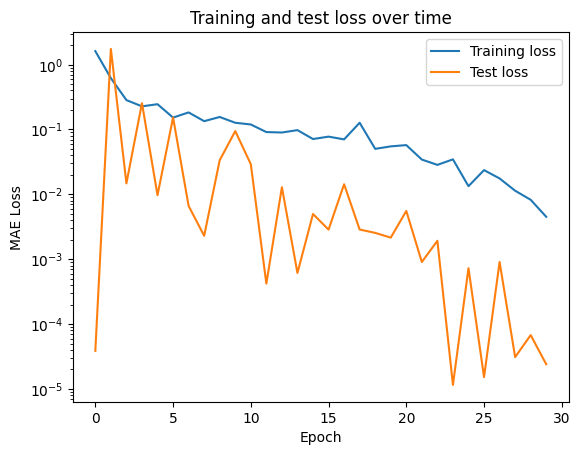

In [21]:
# Plot training and test losses
plt.plot(range(len(loss_list)), loss_list, label="Training loss")
plt.plot(range(len(loss_list)), acc_list, label="Test loss")
plt.title("Training and test loss over time")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.yscale("log")
plt.legend()
plt.show()

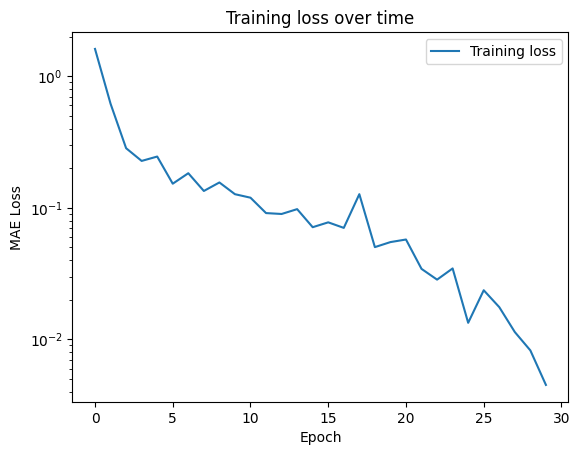

In [22]:
plt.plot(range(len(loss_list)), loss_list, label="Training loss")
plt.title("Training loss over time")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.yscale("log")
plt.legend()
plt.show()

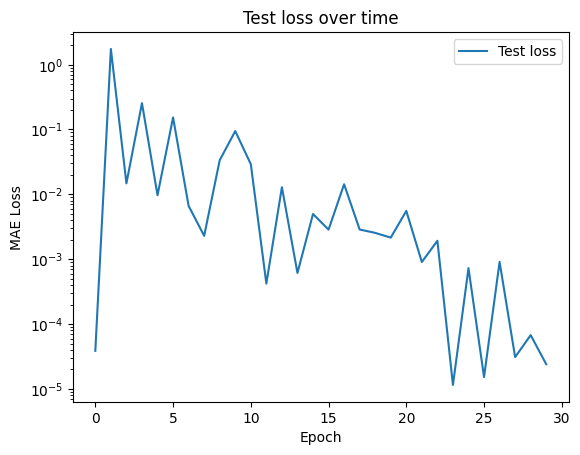

In [23]:
plt.plot(range(len(loss_list)), acc_list, label="Test loss")
plt.title("Test loss over time")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.yscale("log")
plt.legend()
plt.show()